### Calibration

<h4>Brier and Log Loss score</h4>

<div class="alert alert-block alert-info">
Both metrics are examples of proper scoring rules measuring the accuracy of forecasts.</div>

In [2]:
import numpy as np
import pandas as pd

np.random.seed(0)

import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.model_selection import train_test_split

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [3]:
# Given AUC and event rate, generate a random score
desired_auc = 0.743098992489467  # Adjust to your desired AUC
event_rate = 0.10  # Desired default rate (e.g., 10%)

# Calculate t
t = np.sqrt(np.log(1 / (1 - desired_auc) ** 2))

# Calculate z
z = t - (
    (2.515517 + 0.802853 * t + 0.0103328 * t**2)
    / (1 + 1.432788 * t + 0.189269 * t**2 + 0.001308 * t**3)
)

# Calculate d
d = z * np.sqrt(2)

n_total = 10460

# Calculate the size of each class based on the event rate
n_event = int(n_total * event_rate)
n_non_event = n_total - n_event

# Generate random numbers for the event and non-event classes
x_event = np.random.normal(d, 1, n_event)
x_non_event = np.random.normal(0, 1, n_non_event)

# Concatenate the event and non-event classes
x = np.concatenate((x_non_event, x_event))
y = np.concatenate((np.zeros(n_non_event), np.ones(n_event)))

# Desired properties of the logit score
desired_mean = -2.164129
desired_std = 0.399522
desired_min = -2.935578
desired_q1 = -2.361274
desired_median = -2.121932
desired_q3 = -1.893792
desired_max = -1.173120

# Adjust the generated data to match the desired quartiles and max
x = (x - np.mean(x)) * (desired_std / np.std(x)) + desired_mean
x_min = np.min(x)
x_range = np.max(x) - x_min
x = (x - x_min) * (desired_max - desired_min) / x_range + desired_min

y_pred = 1 / (1 + np.exp(-x))

(1.0849970999999996, 3.0237009, 0.0, 334.95)

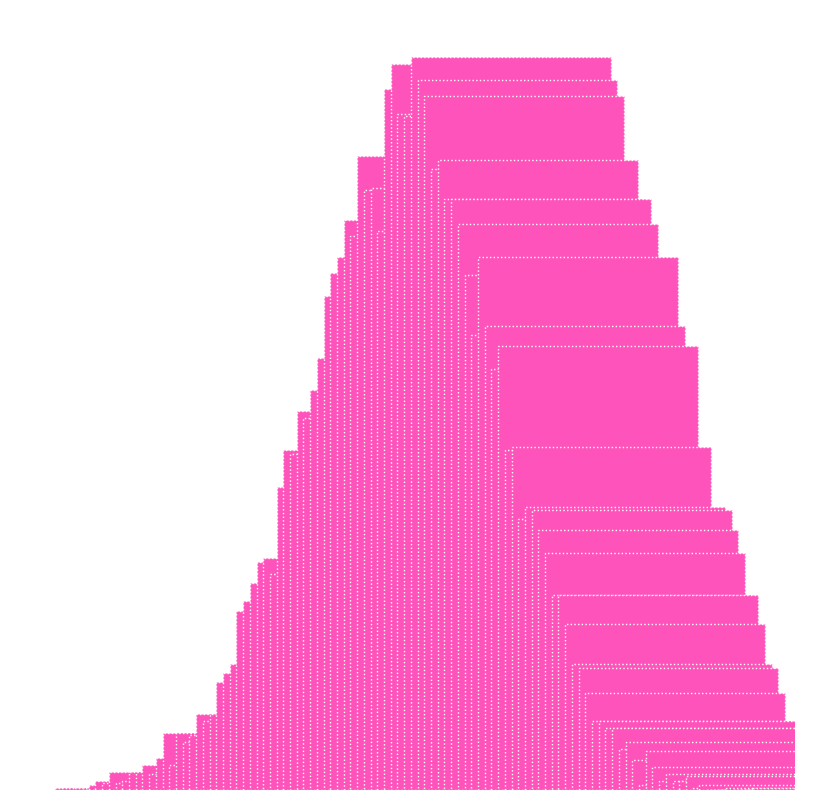

In [4]:
hist_data = pd.Series(-x)
n_bins = round(len(x) / 100)

plt.figure(figsize=(5, 5), dpi=100)  # Set figure size
# Plot the histogram
plt.hist(
    hist_data, 
    bins=n_bins, 
    color='#fe53bb',
    width=0.5, 
    edgecolor='white',
    linestyle='dotted',
    linewidth=0.5,
    )
plt.grid(False)
plt.axis('off')  # Turn off axes

In [5]:
brier_score = brier_score_loss(y, y_pred)
log_loss_score = log_loss(y, y_pred)
print(f"Brier score: {brier_score:.2%}")
print(f"Log Loss score: {log_loss_score:.2%}")

Brier score: 8.68%
Log Loss score: 31.02%


<h4>Expected Calibration Error (ECE)</h4>


<div class="alert alert-block alert-info">
<b>ECE</b> can be used to quantify how well a given model is calibrated e.g. how well the predicted output probabilities of the model matches the actual probabilities of the ground truth distribution. Three different norms are implemented, each corresponding to variations on the calibration error metric.</div>

In [6]:
def calculate_ece(y_true, y_prob, n_bins=10, min_proba=0.0, max_proba=1.0) -> float:
    """
    Calculate Expected Calibration Error (ECE) for binary classification using NumPy.

    Parameters:
    - y_true: True labels.
    - y_prob: Predicted probabilities for the positive class.
    - n_bins: Number of bins for calibration. (default: 10)
    - min_proba: Minimum predicted probability. (default: 0.0)
    - max_proba: Maximum predicted probability. (default: 1.0)

    Returns:
    - ece: Expected Calibration Error.
    """

    # Define bin ranges
    bins = np.linspace(min_proba, max_proba, n_bins)

    # Return the indices of the bins to which each value in the input array belongs
    binned_preds = np.digitize(y_prob, bins)

    ece = 0
    bin_true = np.zeros(n_bins)
    bin_pred = np.zeros(n_bins)
    bin_size = np.zeros(n_bins)

    for bin_idx in range(n_bins):
        bin_size[bin_idx] = np.sum(binned_preds == bin_idx)
        if bin_size[bin_idx] > 0:
            bin_true[bin_idx] = (
                np.sum(y_true[binned_preds == bin_idx]) / bin_size[bin_idx]
            )
            bin_pred[bin_idx] = (
                np.sum(y_prob[binned_preds == bin_idx]) / bin_size[bin_idx]
            )
            abs_difference = np.abs(bin_true[bin_idx] - bin_pred[bin_idx])
            ece += (bin_size[bin_idx] / len(y_true)) * abs_difference

    return round(ece, 4)

In [7]:
ece_score = calculate_ece(y, y_pred)
print(f"ECE score: {ece_score:.2%}")

ECE score: 3.59%
